In [1]:
# # aws dependencies
# %pip install awswrangler

# # guara dependencies
# %pip install lightgbm
# %pip install shap
# %pip install optuna
# %pip install great_expectations
# %pip install unidecode

In [2]:
# general libs
import os
import re
import sys
import nltk 
import heapq
import boto3
import string
import difflib
import sagemaker
import numpy as np 
import pandas as pd
import seaborn as sn
import awswrangler as wr
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
nltk.download('punkt')

# guara libs
from sklearn.pipeline import Pipeline
sys.path.append(os.path.dirname(os.getcwd())+'/src')
from guara.modeling.supervised_modelz import SupervisedModelz

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load data

In [5]:
# carregar datasets

df_2020 =  wr.s3.read_excel(path='s3://br-accamargo-rawdata-dev/Laudo_classificacao_2020.xlsx', engine='openpyxl')
df_2020.columns = df_2020.columns.str.lower()
df_2020.rename(columns={'(1) câncer / (2) não câncer':'cancer', 'texto_diagnostico_resumo':'resumo'}, inplace=True)

df_2015 =  wr.s3.read_excel(path='s3://br-accamargo-rawdata-dev/Classificao_laudos_2015.xlsx', engine='openpyxl')
df_2015.columns = df_2015.columns.str.lower()
df_2015.rename(columns={'cancer/não cancer':'cancer'}, inplace=True)

df_2016 =  wr.s3.read_excel(path='s3://br-accamargo-rawdata-dev/Classificao_laudos_2016.xlsx', engine='openpyxl')
df_2016.columns = df_2016.columns.str.lower()
df_2016.rename(columns={'cancer/naocancer':'cancer'}, inplace=True)

df_2018 =  wr.s3.read_excel(path='s3://br-accamargo-rawdata-dev/Classificacao_laudo2018.xlsx', engine='openpyxl')
df_2018.columns = df_2018.columns.str.lower()
df_2018.rename(columns={'(1) câncer |(2) não câncer':'cancer','n_laudo':'laudo'}, inplace=True)

In [6]:
df = pd.concat([df_2015, df_2016, df_2018, df_2020], axis=0)
df['data'] = pd.to_datetime(df['data'])
df.sort_values(by='data', inplace=True)
df.reset_index(inplace=True)
df

,index,rgh,identificador,laudo,data,cancer,texto_diagnostico_resumo,resumo
0,14737,50017461,NaN,NaN,2015-01-02,2,[* O teste HER2 pelo método imunoistoquímico d...,NaN
1,6413,13452300,NaN,NaN,2015-01-02,2,[* O teste HER2 pelo método imunoistoquímico d...,NaN
2,6215,13430030,NaN,NaN,2015-01-02,2,[* O teste HER2 pelo método imunoistoquímico d...,NaN
3,6306,13439720,1683714_1571H14-006679,H14-006679,2015-01-02,2,"[* Hiperplasia ductal usual, * Adenose simples...",NaN
4,6450,13455020,1685133_1574H14-006866,H14-006866,2015-01-02,1,[* Carcinoma ductal microinvasivo associado a ...,NaN
...,...,...,...,...,...,...,...,...
78664,6246,15960700,2005349446H20-034830,H20-034830,2020-12-31,2,NaN,"[* Gastrite crônica leve, em mucosa de padrão ..."
78665,4204,14341020,2005344451H20-034803,H20-034803,2020-12-31,2,NaN,[* Fragmentos de parênquima pulmonar evidencia...
78666,6064,15912050,2005352636H20-034878,H20-034878,2020-12-31,2,NaN,"[* Gastrite crônica leve, em mucosa de padrão ..."
78667,6137,15935010,2005351076H20-034857,H20-034857,2020-12-31,2,NaN,[* Mucosa de transição esôfago-gástrica exibin...


In [7]:
# lendo datasets atualizados
laudos_list=[]

s3 = boto3.resource('s3', region_name='us-east-1', verify=False)
bucket = s3.Bucket('br-accamargo-rawdata-dev')

for files in bucket.objects.filter(Prefix='laudos_novo/LAUDOS'):
    laudos_list.append(wr.s3.read_parquet(path='s3://br-accamargo-rawdata-dev/'+str(files.key)))

Unverified HTTPS request is being made to host 'br-accamargo-rawdata-dev.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings


In [8]:
# concatenação dos datasets atualizados
laudos = pd.concat(laudos_list, axis=0)
laudos.columns = laudos.columns.str.lower()
laudos.rename(columns={'testodiagnosi':'texto','codigo_interno':'laudo'}, inplace=True)
laudos.drop_duplicates(inplace=True)
print(laudos.info())
laudos.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213318 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   laudo                 213318 non-null  string
 1   rgh                   213316 non-null  string
 2   dataliberacao         213318 non-null  string
 3   descrizione           213318 non-null  string
 4   codice                213318 non-null  string
 5   texto                 213314 non-null  string
 6   testodiagnosicitotec  0 non-null       string
dtypes: string(7)
memory usage: 13.0 MB
None


,laudo,rgh,dataliberacao,descrizione,codice,texto,testodiagnosicitotec
0,H18-000071,15354940,04/01/2018,REVISAO DE CASO (LAMINA) EXTERNO,REV_EXT,Biópsia de pulmão: * Carcinoma epidermóide ...,<NA>
1,H18-000072,13832650,05/01/2018,BIOPSIA,BIO,1 Biópsia de lesão em amígdala direita: * P...,<NA>
2,H20-003157,13832650,04/02/2020,BIOPSIA,BIO,1 Biópsia de pele em peitoral esquerdo: * N...,<NA>
3,H18-000396,15360500,09/01/2018,BIOPSIA,BIO,1 Biópsia de pulmão direito: * Adenocarcino...,<NA>
4,H19-001989,15079600,31/01/2019,PEÇA CIRÚRGICA,PC,1 Esvaziamento cervical nível II B à direita ...,<NA>


In [9]:
# juntar df e laudos pela coluna laudo
full_df = pd.merge(left=df, right=laudos, on=['laudo'], how='inner')

In [10]:
# filtrar o dataframe: colunas = [df.id, laudo.laudo, df.rotulo]
full_df = full_df#[['laudo','texto','cancer']]
full_df['cancer'] = abs(full_df['cancer']-2)
full_df.head()

,index,rgh_x,identificador,laudo,data,cancer,texto_diagnostico_resumo,resumo,rgh_y,dataliberacao,descrizione,codice,texto,testodiagnosicitotec
0,6306,13439720,1683714_1571H14-006679,H14-006679,2015-01-02,0,"[* Hiperplasia ductal usual, * Adenose simples...",NaN,13439720,02/01/2015,BIOPSIA,BIO,Biópsia de mama esquerda: * Hiperplasia duc...,<NA>
1,6450,13455020,1685133_1574H14-006866,H14-006866,2015-01-02,1,[* Carcinoma ductal microinvasivo associado a ...,NaN,13455020,02/01/2015,REVISAO DE CASO (LAMINA) EXTERNO,REV_EXT,Biópsia mamária assistida a vácuo orientada ...,<NA>
2,6313,13440070,1685541_1576H14-006909,H14-006909,2015-01-02,1,"[* Carcinoma lobular invasivo, * Carcinoma lob...",NaN,13440070,02/01/2015,PER-OPERATÓRIO PEÇA CIRÚRGICA,CONG_PEÇA,Produto de ressecção segmentar de mama direita...,<NA>
3,6601,13463010,1686779_1574H14-006978,H14-006978,2015-01-02,1,"[* Lesão papilífera complexa, associada a prol...",NaN,13463010,02/01/2015,REVISAO DE CASO (LAMINA) EXTERNO,REV_EXT,Core biopsy de mama direita (JQL - 9h): * Les...,<NA>
4,5961,13386540,1681804_1572H14-006512,H14-006512,2015-01-02,1,"[* Carcinoma ductal in situ, tipos sólido, cri...",NaN,13386540,02/01/2015,PEÇA CIRÚRGICA,PC,Produto de mastectomia à esquerda e prolonga...,<NA>


# Analise Exploratória

In [11]:
full_df.head()[['texto', 'cancer']].values

array([['\r\nBiópsia de mama esquerda:\r\n* Hiperplasia ductal usual\r\n* Adenose simples\r\n* Metaplasia apócrina\r\n* Alteração de células colunares sem atipias\r\n* Microcalcificações intraluminais\r\n\r\n\r\nNotas:\r\n1- Este diagnóstico considerou a realização de novos cortes aprofundados do bloco de parafina para melhor avaliação histológica.\r\n2- No material examinado não há indícios morfológicos de malignidade.\r\n',
        0],
       ['\r\nBiópsia mamária assistida a vácuo orientada por estereotaxia:\r\n* Carcinoma ductal microinvasivo associado a extenso componente de carcinoma ductal in situ.\r\n. Graduação: não avaliável.\r\n. Grau nuclear: 3.\r\n. Formação tubular: 3.\r\n. Índice mitótico: não há 10 campos de grande aumento para avaliação.\r\n. Necrose: ausente.\r\n. Reação desmoplásica: moderada.\r\n. Infiltrado inflamatório no estroma tumoral: leve.\r\n. Invasão vascular sangüínea: não detectada.\r\n. Invasão vascular linfática: não detectada.\r\n. Invasão perineural: 

In [12]:
full_df.shape

(74986, 14)

In [13]:
full_df.cancer.value_counts(normalize=True)

0    0.606393
1    0.393607
Name: cancer, dtype: float64

# Modelagem

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

In [15]:
import nltk
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.util import bigrams
from nltk.misc import babelize_shell
from unidecode import unidecode
from nltk import tokenize

def processa_texto_(texto, return_ = 'string'):
    # stemmer = nltk.stem.RSLPStemmer()
    stemmer = nltk.stem.SnowballStemmer(language = 'portuguese')
    stopwords=nltk.corpus.stopwords.words('portuguese')
   


    # separa em palavras
    token = tokenize.word_tokenize(texto.lower(), language='portuguese')
    # retira stopwords
    token = [word for word in token if word not in stopwords]
    # retira palavras pre selecionadas
    #token = [word for word in token if len(word) > 2]
    # retira numeros 
    token = [ word if word.isalpha() else '#NUM' for word in token ]
    # tira caracteres especiais  e faz stemmizacao
    token = [unidecode(stemmer.stem(word)) for word in token]



    if return_ == 'string':
        return ' '.join(token)
    elif return_ == 'list':
        return token

    
class ProcessaTexto(BaseEstimator, TransformerMixin):

    def __init__(self, col):
        self.col=col
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
     
        X['texto_tratado'] = X[self.col].replace('\§', ' ENTER ', regex = True)
        X['texto_tratado'] = X['texto_tratado'].replace(['\"', '-'], '', regex = True)
        X['texto_tratado'] = X['texto_tratado'].replace(['\"', '\*'], ' ', regex = True)
        X['texto_tratado'] = X['texto_tratado'].replace([ '\/', '\.', '\,', '\;'], ' punkt ', regex = True)
        X['texto_tratado'] = X['texto_tratado'].apply(lambda x: processa_texto_(x))
        
        return X

In [16]:
class CountVectorizerPandas(BaseEstimator, TransformerMixin):
    """
    Performs bag of words on a column
    args:
        max_features: maximum number of features
    
    """  
    
    def __init__(self, max_features):
        self.cv = None
        self.max_features = max_features
        
    def fit(self, X, y=None):
        
        self.col = 'texto_tratado'
        
        self.cv =  CountVectorizer(max_features=self.max_features)
                           
        self.cv.fit(X[self.col])
        
        return self


    def transform(self, X):
        #assert isinstance(X, pd.DataFrame)
        
        Xt = self.cv.transform(X[self.col]).todense()
        Xt = pd.DataFrame(Xt, columns = self.cv.get_feature_names(), index=X.index)
        
        return Xt  

In [17]:
# split dos dados - 70% para treino e 30% para validação
x_train, x_test, y_train, y_test = train_test_split(
    full_df[['laudo','texto']], 
    full_df['cancer'], 
    train_size=0.7, 
    shuffle=True,
    random_state=123
    )


# aplicar pipeline com transformações
pipe = Pipeline([
    ('preproc', ProcessaTexto('texto')),
    ('bag', CountVectorizerPandas(max_features=250))
])

x_train = pipe.fit_transform(x_train)
x_test = pipe.transform(x_test)

In [18]:
x_train.head()

,achad,acin,acomet,actin,adenocarcinom,adenom,adenos,adip,adjacent,agreg,...,tub,tubul,tumor,tumoral,ulcer,urological,usual,uterin,vascul,vid
2931,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50051,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39822,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43902,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
print('x_train shape: ', x_train.shape, 'y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape, 'y_test shape: ', y_test.shape)

x_train shape:  (52490, 250) y_train shape:  (52490,)
x_test shape:  (22496, 250) y_test shape:  (22496,)


In [20]:
# modelagem
md = SupervisedModelz('lgbm', 'binary')

params = {
    'random_state': 501,
    'boosting_type': 'gbdt',
    'device_type': 'cpu',
    'is_unbalanced':'true',
    'learning_rate': 0.01,
    'colsample_bytree': 0.7,
    'max_depth': 20,
    'n_estimators': 500,
    'sub_sample': 0.8,
    'num_leaves': 10,
    'min_child_samples': 24,
 }

model = md.fit(x_train, x_test, y_train, y_test, params)

Treinando o modelo LGBM, objetivo BINARY... 



Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Info] Number of positive: 20735, number of negative: 31755
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2809
[LightGBM] [Info] Number of data points in the train set: 52490, number of used features: 250
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.395028 -> initscore=-0.426227
[LightGBM] [Info] Start training from score -0.426227
Modelo treinado em 0.08 minutos 



Model best iteration: 500

BINARY_LOGLOSS loss:
Train: 0.1237
Val  : 0.1268


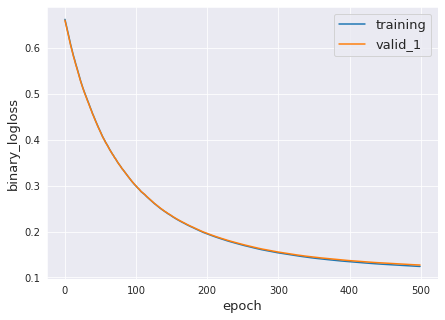

In [21]:
md.plot_train_info()

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


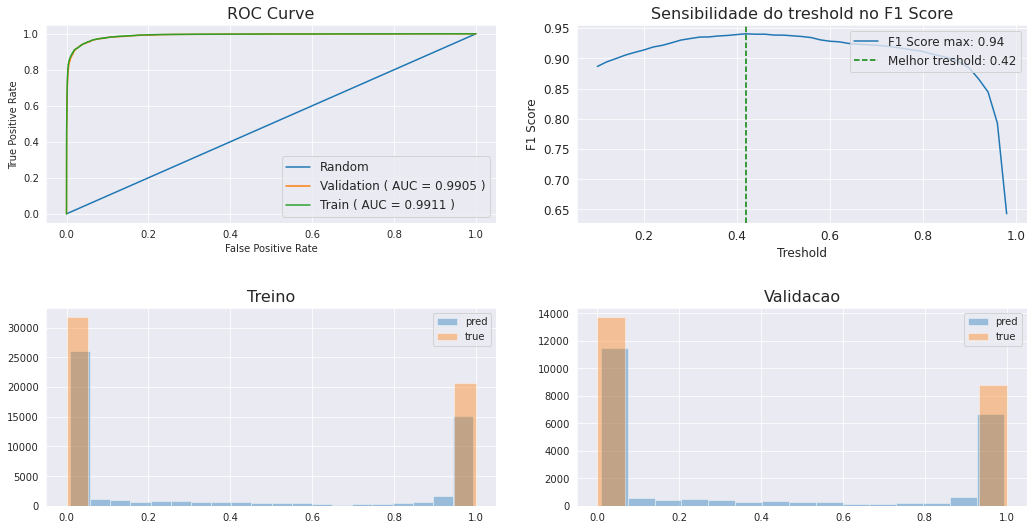

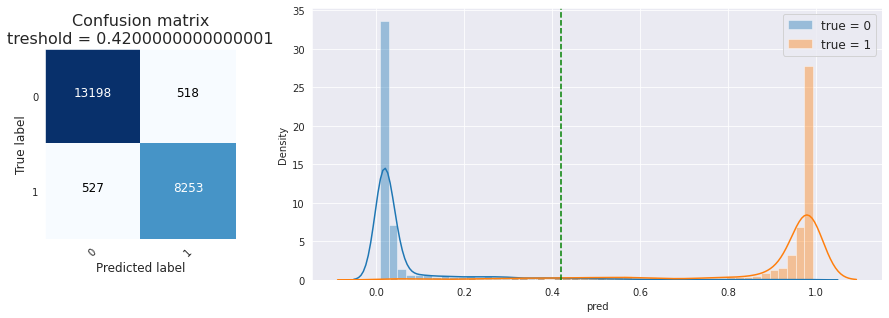


              precision    recall  f1-score   support

           0       0.96      0.96      0.96     13716
           1       0.94      0.94      0.94      8780

    accuracy                           0.95     22496
   macro avg       0.95      0.95      0.95     22496
weighted avg       0.95      0.95      0.95     22496



In [22]:
ytrain_pred = md.predict(x_train)
yval_pred = md.predict(x_test)

md.evaluation_plots(y_train.values, ytrain_pred, y_test.values, yval_pred)

In [23]:
# shap
df_shap = md.init_shap(x_test)

df_shap.head()

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


,achad,acin,acomet,actin,adenocarcinom,adenom,adenos,adip,adjacent,agreg,...,tub,tubul,tumor,tumoral,ulcer,urological,usual,uterin,vascul,vid
0,0.0,0.0,-0.001031,0.0,-0.308159,0.019154,0.0,0.0017,0.000093,0.000779,...,0.0,0.000469,-0.012499,0.0,0.0,0.0,0.0,0.0,-0.001518,0.0
1,0.0,0.0,-0.000419,0.0,-0.304773,0.012492,0.0,0.0017,0.000093,0.000753,...,0.0,0.000469,-0.011675,0.0,0.0,0.0,0.0,0.0,-0.001673,0.0
2,0.0,0.0,-0.000269,0.0,-0.303333,0.012659,0.0,0.0017,0.000093,0.000723,...,0.0,0.000469,-0.011971,0.0,0.0,0.0,0.0,0.0,-0.001673,0.0
3,0.0,0.0,-0.001031,0.0,-0.250863,0.017654,0.0,0.0017,0.000093,0.002225,...,0.0,0.000469,-0.008328,0.0,0.0,0.0,0.0,0.0,-0.004881,0.0
4,0.0,0.0,-0.000914,0.0,-0.312560,0.011384,0.0,0.0017,0.000093,-0.024092,...,0.0,0.000469,-0.011923,0.0,0.0,0.0,0.0,0.0,-0.001518,0.0


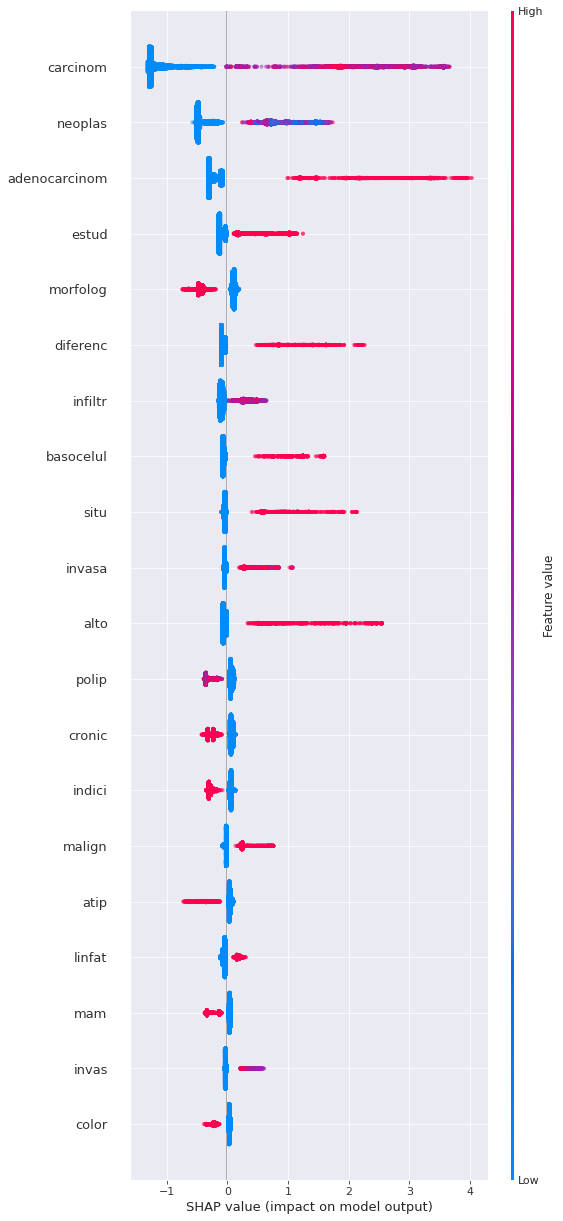

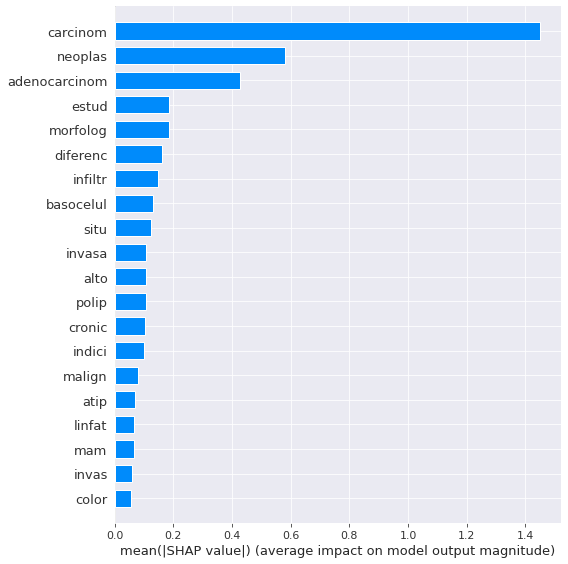

In [24]:
importance = md.shap_importance(x_test)

In [25]:
importance

carcinom         1.449150
neoplas          0.581410
adenocarcinom    0.426470
estud            0.185932
morfolog         0.184222
                   ...   
med              0.000000
margens          0.000000
mamari           0.000000
localiz          0.000000
achad            0.000000
Length: 250, dtype: float64